In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sn
import re

import tensorflow as tf 
import tensorflow.keras as keras 

import sklearn.model_selection as model_selection
import sklearn.metrics as metrics_model
import sklearn.linear_model as linear_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/glove.6B.zip

Archive:  /content/drive/MyDrive/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
import re
def remove_just_Hash(data):
  data=re.sub('#','',data)
  return data

# Training
we have trained alot of model in this Notebook and
other notebook you cant see all model we have train hear 
becouse I have run the same cell on defrent model.

In [9]:
#This cell import clean data after we save them as DataFrame and make the tokinizer and prepare the 
# data for trainig

#import data
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

#train_set['clean_text']=train_set['clean_text']
#test_set['clean_text']=test_set['clean_text']

X_train=train_set['clean_text'].values
X_test=test_set['clean_text'].values
y_train=train_set['NomericSentiment'].values
y_test=test_set['NomericSentiment'].values

#split train data into train and evaluate
X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['NomericSentiment'],random_state=42)

#convert the label to one_hot vector
y_train=keras.utils.to_categorical(y_train,5)
y_test=keras.utils.to_categorical(y_test,5)
y_val=keras.utils.to_categorical(y_val,5)

#create the tokinizer and fit on the data
tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

#convert data from string to number depending on the tokinizer
X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
X_val=tokinizer.texts_to_sequences(X_val)

#add padding to the data
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=70)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=70)
X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=70)



45832


In [10]:
# read the embbeding file and create dictionary of word
embading_index={}
path = '/content/glove.6B.300d.txt'
with open(path) as f:
  for line in f:
    key,value=line.split(maxsplit=1)
    value=np.fromstring(value,"f",sep=" ")
    embading_index[key]=value

print("Found {} word vector".format(len(embading_index)))

# create embbeding matrix to use as intial wight in the model
embading_dim=300
num_tokens=vocab_size
hit=0
miss=0

embading_matrix=np.zeros((num_tokens,embading_dim))

for word,value in tokinizer.word_index.items():
  embading_vector=embading_index.get(word)
  if embading_vector is not None:
      embading_matrix[value]=embading_vector
      hit+=1
  else:miss+=1
print("Hit : {} ,misses: {}".format(hit,miss))

Found 400000 word vector


In [20]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.LSTM(128,return_sequences=True,recurrent_dropout=0.2),
          keras.layers.LSTM(128),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(5,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           13749600  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,101,477
Trainable params: 14,101,477
Non-trainable params: 0
_________________________________________________________________


In [21]:
import tensorflow_addons as tfa
f1=tfa.metrics.F1Score(5)

#### we use The f1_score becouse the data its skew as we mention befor

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy',f1])

we create callbacks for **erlay stop** and **check_point**

the first one stop if the model start overfit according to the val_loss

the second one save the model after each epoch and save the best wight only

In [23]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/LSTM_with_Regulaization_And_clean_#.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

## Trainig 
we train on the **gpu** the first line is for let as use gpu on colab 

then i put the operation i wont do on the **gpu** inside this block

In [24]:

with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=15,validation_data=(X_val_set,y_val),batch_size=32,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/15
823/823 [==============================] - 221s 265ms/step - loss: 1.4853 - accuracy: 0.3248 - f1_score: 0.2642 - val_loss: 1.1406 - val_accuracy: 0.5343 - val_f1_score: 0.5523
Epoch 2/15
823/823 [==============================] - 215s 261ms/step - loss: 1.0098 - accuracy: 0.5988 - f1_score: 0.6074 - val_loss: 0.7766 - val_accuracy: 0.7140 - val_f1_score: 0.7257
Epoch 3/15
823/823 [==============================] - 214s 260ms/step - loss: 0.6931 - accuracy: 0.7526 - f1_score: 0.7603 - val_loss: 0.6520 - val_accuracy: 0.7673 - val_f1_score: 0.7766
Epoch 4/15
823/823 [==============================] - 217s 264ms/step - loss: 0.5518 - accuracy: 0.8149 - f1_score: 0.8194 - val_loss: 0.6376 - val_accuracy: 0.7828 - val_f1_score: 0.7903
Epoch 5/15
823/823 [==============================] - 217s 264ms/step - loss: 0.4513 - accuracy: 0.8552 - f1_score: 0.8598 - val_loss: 0.6765 - val_accuracy: 0.7864 - val_f1_score: 0.7940
Epoch 6/15
823/823 [==============================] - 215s 2

## import model we had saved.
This step its important befor evaluate the data becouse the ModelCheckpoint save best wight we get during 
the Training

In [25]:
model=keras.models.load_model('/content/drive/MyDrive/LSTM_with_Regulaization_And_clean_#.h5')

In [33]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9172, f1_score : [0.9086776  0.9009023  0.9106529  0.94649714 0.94011366]
Testing Accuracy:  0.7886, f1_score : [0.76172453 0.7564692  0.8420325  0.8135461  0.8081672 ]


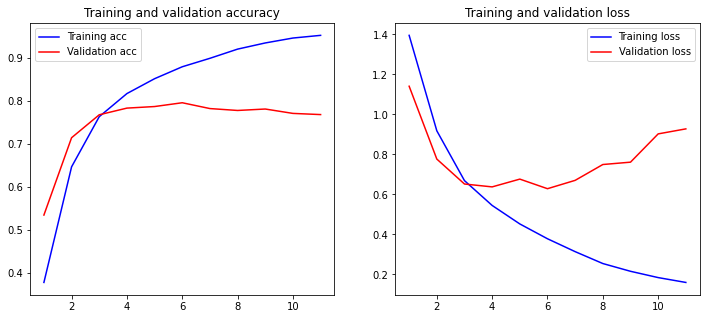

In [27]:
loss, accuracy,f1_score = model.evaluate(X_train_set, y_train, verbose=False)
print("Training Accuracy: {:.4f}, f1_score : {}".format(accuracy,f1_score))
loss, accuracy,f1_score = model.evaluate(X_test_set, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}, f1_score : {}".format(accuracy,f1_score))
plot_history(history)

we can see that this model is the best model until now but we can do better than this

In [ ]:
keras.backend.clear_session()
model_2=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.GRU(128,return_sequences=True,recurrent_dropout=0.2,dropout=0.2),
          keras.layers.GRU(128,recurrent_dropout=0.2,dropout=0.2),
          keras.layers.Dense(5,activation='softmax')
])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           13746600  
_________________________________________________________________
gru (GRU)                    (None, 70, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,011,437
Trainable params: 14,011,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


In [ ]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRURNN_with_Regulaziation.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_2.fit(X_train_set,y_train,epochs=15,validation_data=(X_val_set,y_val),batch_size=64,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/15
412/412 [==============================] - 323s 785ms/step - loss: 1.5563 - accuracy: 0.2858 - val_loss: 1.5714 - val_accuracy: 0.2513
Epoch 2/15
412/412 [==============================] - 326s 792ms/step - loss: 1.2762 - accuracy: 0.4410 - val_loss: 1.1488 - val_accuracy: 0.5086
Epoch 3/15
412/412 [==============================] - 324s 787ms/step - loss: 0.9003 - accuracy: 0.6424 - val_loss: 0.7861 - val_accuracy: 0.7102
Epoch 4/15
412/412 [==============================] - 323s 783ms/step - loss: 0.6935 - accuracy: 0.7410 - val_loss: 0.6520 - val_accuracy: 0.7667
Epoch 5/15
412/412 [==============================] - 314s 761ms/step - loss: 0.5759 - accuracy: 0.7899 - val_loss: 0.6527 - val_accuracy: 0.7589
Epoch 6/15
412/412 [==============================] - 326s 791ms/step - loss: 0.4882 - accuracy: 0.8251 - val_loss: 0.6162 - val_accuracy: 0.7761
Epoch 7/15
412/412 [==============================] - 325s 788ms/step - loss: 0.4121 - accuracy: 0.8557 - val_loss: 0.5919 -

In [ ]:
model_2=keras.models.load_model('/content/drive/MyDrive/GRURNN_with_Regulaziation.h5')

Training Accuracy: 0.9189
Testing Accuracy:  0.7889


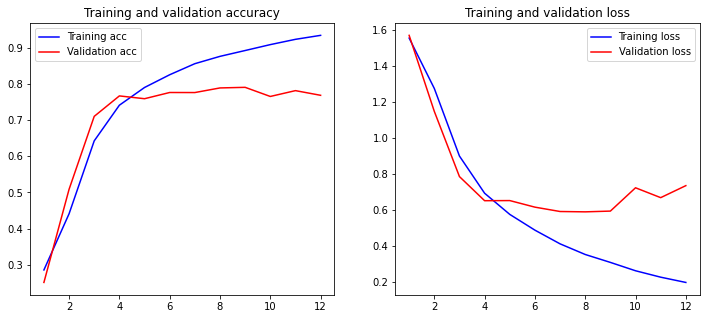

In [ ]:
loss, accuracy = model_2.evaluate(X_train_set, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2.evaluate(X_test_set, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

as we can see the dropout layer make the model do better on the traning and generalize better on the testing now we should do some clean to the data and see how will do 

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
STOPWORDS=stopwords.words('english')

def remove_stop_word_less_than_3_charecter(data):
  min_stop=[w for w in STOPWORDS if len(w)<=3]
  word=data.split()
  res=[w for w in word if w not in min_stop]
  return ' '.join(res)

In [ ]:
def remove_hash(data):
  words=data.split()
  res=[w for w in words if '#' not in w]
  return ' '.join(res)

These two function I am goning to use for cleaning stuf
and I am gone use f1_score instade of accuracy

In [ ]:
import tensorflow_addons  as tfa

In [ ]:
f1=tfa.metrics.F1Score(5)

In [ ]:
keras.backend.clear_session()
model_3=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.GRU(128,return_sequences=True,recurrent_dropout=0.2,dropout=0.2),
          keras.layers.GRU(128,recurrent_dropout=0.2,dropout=0.2),
          keras.layers.Dense(5,activation='softmax')
])
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           13746600  
_________________________________________________________________
gru (GRU)                    (None, 70, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,011,437
Trainable params: 14,011,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])


In [ ]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRURNN_with_Regulaziation_with_f1Score.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_3.fit(X_train_set,y_train,epochs=15,validation_data=(X_val_set,y_val),batch_size=64,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/15
412/412 [==============================] - 362s 879ms/step - loss: 1.5779 - accuracy: 0.2734 - f1_score: 0.1131 - val_loss: 1.5727 - val_accuracy: 0.2825 - val_f1_score: 0.0881
Epoch 2/15
412/412 [==============================] - 358s 868ms/step - loss: 1.3141 - accuracy: 0.4138 - f1_score: 0.3982 - val_loss: 0.9365 - val_accuracy: 0.6303 - val_f1_score: 0.6417
Epoch 3/15
412/412 [==============================] - 358s 869ms/step - loss: 0.6842 - accuracy: 0.7431 - f1_score: 0.7509 - val_loss: 0.6871 - val_accuracy: 0.7231 - val_f1_score: 0.7386
Epoch 4/15
412/412 [==============================] - 359s 872ms/step - loss: 0.4474 - accuracy: 0.8418 - f1_score: 0.8480 - val_loss: 0.6036 - val_accuracy: 0.7776 - val_f1_score: 0.7870
Epoch 5/15
412/412 [==============================] - 337s 818ms/step - loss: 0.3140 - accuracy: 0.8910 - f1_score: 0.8956 - val_loss: 0.6375 - val_accuracy: 0.7840 - val_f1_score: 0.7918
Epoch 6/15
412/412 [==============================] - 343s 8

In [ ]:
model_3=keras.models.load_model('/content/drive/MyDrive/GRURNN_with_Regulaziation_with_f1Score.h5')

823/823 [==============================] - 52s 63ms/step - loss: 0.3017 - accuracy: 0.9037 - f1_score: 0.9096
Training Accuracy:0.9037183523178101 , f1_score 0.909615159034729
258/258 [==============================] - 16s 61ms/step - loss: 0.6089 - accuracy: 0.7780 - f1_score: 0.7858
Testing Accuracy:  0.7780, f1_score 0.7858


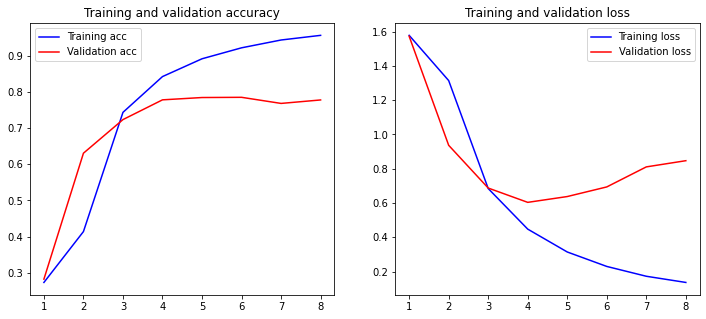

In [ ]:

loss, accuracy ,f1_score = model_3.evaluate(X_train_set, y_train)
print("Training Accuracy:{} , f1_score {}".format(accuracy,np.average(f1_score)))
loss, accuracy ,f1_score = model_3.evaluate(X_test_set, y_test)
print("Testing Accuracy:  {:.4f}, f1_score {:.4f}".format(accuracy,np.mean(f1_score)))
plot_history(history)

we still have overfit

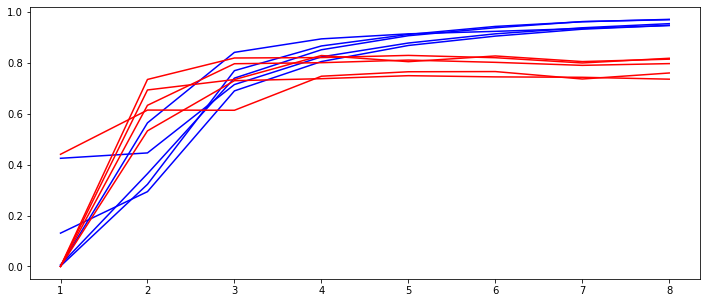

In [ ]:
f1_s=np.mean(history.history['f1_score'])
f1_s_val=np.mean(history.history['val_f1_score'])
x = range(1, len(f1_s) + 1)
plt.figure(figsize=(12, 5))
plt.plot(x, f1_s, 'b', label='Training acc')
plt.plot(x, f1_s_val, 'r', label='Validation acc')

as we can see if we use f1_score we get evaluate for each class not all class togather and this give as 
more information about the class that model mis classification it


**now we will remove stop word that have less than three charecter**

In [ ]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(remove_stop_word_less_than_3_charecter)
test_set['clean_text_1']=test_set['clean_text'].apply(remove_stop_word_less_than_3_charecter)

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['NomericSentiment'].values
y_test=test_set['NomericSentiment'].values

X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,random_state=42)

y_train=keras.utils.to_categorical(y_train,5)
y_test=keras.utils.to_categorical(y_test,5)
y_val=keras.utils.to_categorical(y_val,5)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=50)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=50)
X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=50)



43721


In [ ]:
embading_dim=300
num_tokens=vocab_size
hit=0
miss=0

embading_matrix=np.zeros((num_tokens,embading_dim))

for word,value in tokinizer.word_index.items():
  embading_vector=embading_index.get(word)
  if embading_vector is not None:
      embading_matrix[value]=embading_vector
      hit+=1
  else:miss+=1
print("Hit : {} ,misses: {}".format(hit,miss))

Hit : 27150 ,misses: 16570


In [ ]:
keras.backend.clear_session()
model_4=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=50),
          keras.layers.LSTM(128,return_sequences=True,recurrent_dropout=0.2,dropout=0.2),
          keras.layers.LSTM(128,recurrent_dropout=0.2,dropout=0.2),
          keras.layers.Dense(5,activation='softmax')
])
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           13116300  
_________________________________________________________________
lstm (LSTM)                  (None, 50, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 13,468,177
Trainable params: 13,468,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])

In [ ]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/LSTMRNN_with_Regulaziation_with_f1Score_and_Clan_StopWords.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_4.fit(X_train_set,y_train,epochs=15,validation_data=(X_val_set,y_val),batch_size=64,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/15
412/412 [==============================] - 308s 748ms/step - loss: 1.1679 - accuracy: 0.5058 - f1_score: 0.5675 - val_loss: 0.9093 - val_accuracy: 0.6432 - val_f1_score: 0.6501
Epoch 2/15
412/412 [==============================] - 317s 768ms/step - loss: 0.7316 - accuracy: 0.7312 - f1_score: 0.7396 - val_loss: 0.7140 - val_accuracy: 0.7456 - val_f1_score: 0.7519
Epoch 3/15
412/412 [==============================] - 319s 774ms/step - loss: 0.5510 - accuracy: 0.8137 - f1_score: 0.8197 - val_loss: 0.7033 - val_accuracy: 0.7615 - val_f1_score: 0.7694
Epoch 4/15
412/412 [==============================] - 301s 730ms/step - loss: 0.4479 - accuracy: 0.8572 - f1_score: 0.8621 - val_loss: 0.7814 - val_accuracy: 0.7442 - val_f1_score: 0.7514
Epoch 5/15
412/412 [==============================] - 300s 729ms/step - loss: 0.3843 - accuracy: 0.8816 - f1_score: 0.8856 - val_loss: 0.8070 - val_accuracy: 0.7433 - val_f1_score: 0.7532
Epoch 6/15
412/412 [==============================] - 299s 7

In [ ]:
model_4=keras.models.load_model('/content/drive/MyDrive/LSTMRNN_with_Regulaziation_with_f1Score_and_Clan_StopWords.h5')

Training Accuracy:0.8846 , f1_score [0.8737786  0.85671145 0.9018984  0.91504335 0.8969646 ]
Testing Accuracy:  0.7560, f1_score [0.73406965 0.69856703 0.82241726 0.79852396 0.76313365]


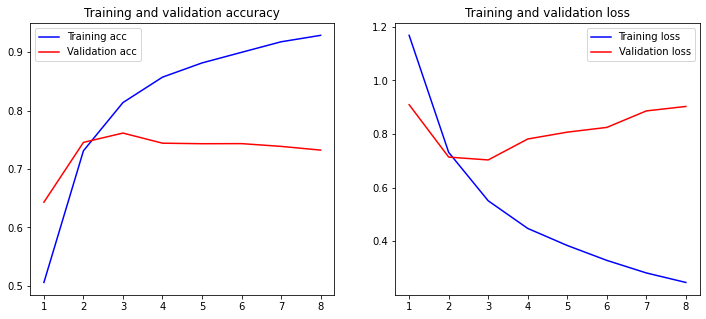

In [ ]:
loss, accuracy ,f1_score = model_4.evaluate(X_train_set, y_train,verbose=False)
print("Training Accuracy:{:.4f} , f1_score {}".format(accuracy,f1_score))
loss, accuracy ,f1_score = model_4.evaluate(X_test_set, y_test,verbose=False)
print("Testing Accuracy:  {:.4f}, f1_score {}".format(accuracy,f1_score))
plot_history(history)

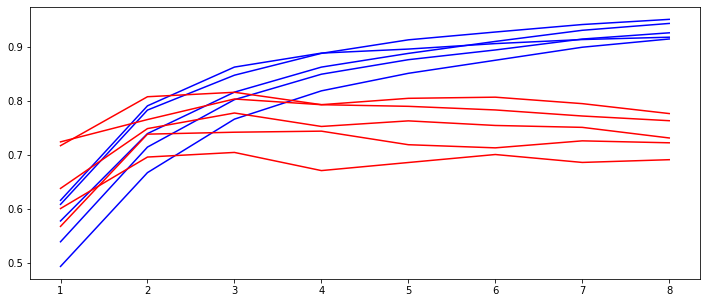

In [ ]:
f1_s=history.history['f1_score']
f1_s_val=history.history['val_f1_score']
x = range(1, len(f1_s) + 1)
plt.figure(figsize=(12, 5))
plt.plot(x, f1_s, 'b', label='Training acc')
plt.plot(x, f1_s_val, 'r', label='Validation acc')

Its not good as befor so i thenk for now that remove stop words its not good idea

we will train lstm without remove stop word

In [ ]:
keras.backend.clear_session()
model_5=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.LSTM(128,return_sequences=True),
          keras.layers.LSTM(128),
          keras.layers.Dense(32,activation='relu'),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(5,activation='softmax')
])
model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           13746600  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 14,102,125
Trainable params: 14,102,125
Non-trainable params: 0
____________________________________________

In [ ]:
model_5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])


In [ ]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/LSTMRNN_with_Regulaziation_with_f1Score_1.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_5.fit(X_train_set,y_train,epochs=15,validation_data=(X_val_set,y_val),batch_size=64,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/15
412/412 [==============================] - 90s 218ms/step - loss: 1.4315 - accuracy: 0.3456 - f1_score: 0.4025 - val_loss: 1.2933 - val_accuracy: 0.4117 - val_f1_score: 0.3472
Epoch 2/15
412/412 [==============================] - 93s 226ms/step - loss: 1.2094 - accuracy: 0.4799 - f1_score: 0.4337 - val_loss: 1.1035 - val_accuracy: 0.5292 - val_f1_score: 0.4804
Epoch 3/15
412/412 [==============================] - 91s 221ms/step - loss: 0.8220 - accuracy: 0.6942 - f1_score: 0.7003 - val_loss: 0.7315 - val_accuracy: 0.7401 - val_f1_score: 0.7499
Epoch 4/15
412/412 [==============================] - 91s 221ms/step - loss: 0.5595 - accuracy: 0.8169 - f1_score: 0.8237 - val_loss: 0.6983 - val_accuracy: 0.7652 - val_f1_score: 0.7750
Epoch 5/15
412/412 [==============================] - 78s 188ms/step - loss: 0.4249 - accuracy: 0.8720 - f1_score: 0.8772 - val_loss: 0.7019 - val_accuracy: 0.7668 - val_f1_score: 0.7753
Epoch 6/15
412/412 [==============================] - 77s 186ms/s

In [ ]:
model_5=keras.models.load_model('/content/drive/MyDrive/LSTMRNN_with_Regulaziation_with_f1Score_1.h5')

Training Accuracy:0.8834 , f1_score [0.8767314  0.8398455  0.91094035 0.92745745 0.89079165]
Testing Accuracy:  0.7661, f1_score [0.74510676 0.7210418  0.8302544  0.79906726 0.7764815 ]


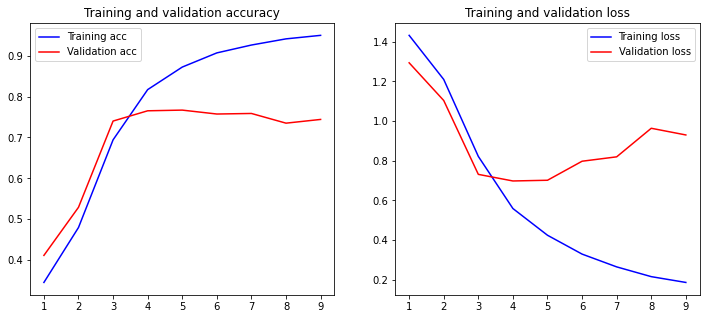

In [ ]:
loss, accuracy ,f1_score = model_5.evaluate(X_train_set, y_train,verbose=False)
print("Training Accuracy:{:.4f} , f1_score {}".format(accuracy,f1_score))
loss, accuracy ,f1_score = model_5.evaluate(X_test_set, y_test,verbose=False)
print("Testing Accuracy:  {:.4f}, f1_score {}".format(accuracy,f1_score))
plot_history(history)

In [ ]:
keras.backend.clear_session()
model_6=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.LSTM(128),
          keras.layers.Dense(32,activation='relu'),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(5,activation='softmax')
])
model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           13746600  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 13,970,541
Trainable params: 13,970,541
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_6.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])

In [ ]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/LSTMRNN_with_Regulaziation_with_f1Score_2.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_6.fit(X_train_set,y_train,epochs=15,validation_data=(X_val_set,y_val),batch_size=64,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/15
412/412 [==============================] - 82s 200ms/step - loss: 1.4473 - accuracy: 0.3396 - f1_score: 0.4057 - val_loss: 1.1566 - val_accuracy: 0.5162 - val_f1_score: 0.5323
Epoch 2/15
412/412 [==============================] - 85s 205ms/step - loss: 0.9695 - accuracy: 0.6252 - f1_score: 0.6377 - val_loss: 0.8102 - val_accuracy: 0.6998 - val_f1_score: 0.7115
Epoch 3/15
412/412 [==============================] - 84s 204ms/step - loss: 0.7066 - accuracy: 0.7557 - f1_score: 0.7644 - val_loss: 0.7064 - val_accuracy: 0.7491 - val_f1_score: 0.7579
Epoch 4/15
412/412 [==============================] - 70s 171ms/step - loss: 0.5283 - accuracy: 0.8347 - f1_score: 0.8402 - val_loss: 0.7132 - val_accuracy: 0.7621 - val_f1_score: 0.7702
Epoch 5/15
412/412 [==============================] - 70s 170ms/step - loss: 0.4257 - accuracy: 0.8759 - f1_score: 0.8803 - val_loss: 0.7258 - val_accuracy: 0.7600 - val_f1_score: 0.7687
Epoch 6/15
412/412 [==============================] - 70s 169ms/s

Training Accuracy:0.9589 , f1_score [0.95200866 0.95547754 0.9457381  0.9729029  0.9803363 ]
Testing Accuracy:  0.7550, f1_score [0.7371123  0.71978563 0.78858715 0.79442775 0.7672658 ]


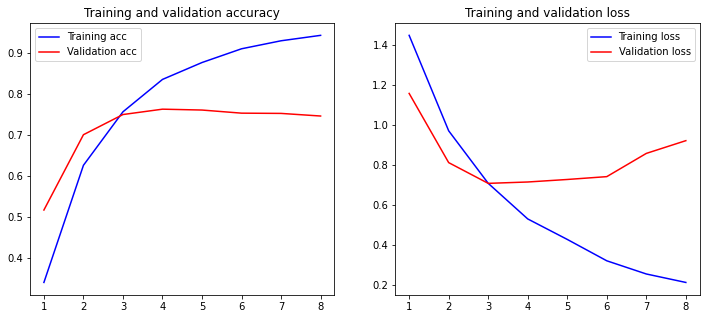

In [ ]:
loss, accuracy ,f1_score = model_6.evaluate(X_train_set, y_train,verbose=False)
print("Training Accuracy:{:.4f} , f1_score {}".format(accuracy,f1_score))
loss, accuracy ,f1_score = model_6.evaluate(X_test_set, y_test,verbose=False)
print("Testing Accuracy:  {:.4f}, f1_score {}".format(accuracy,f1_score))
plot_history(history)

we will train The binary classification on The model we chose GRU_with_regulaziation_clean_# and we will see the result and compare all result of the models we train so far

In [20]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(remove_just_Hash)
test_set['clean_text_1']=test_set['clean_text'].apply(remove_just_Hash)

dic={0:0,1:1,3:0,4:1}

train_set=train_set[train_set['NomericSentiment']!=2]
test_set=test_set[test_set['NomericSentiment']!=2]

train_set['label']=train_set['NomericSentiment'].apply(lambda x:dic[x])
test_set['label']=test_set['NomericSentiment'].apply(lambda x:dic[x])

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['label'].values
y_test=test_set['label'].values


X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['label'],random_state=42)

# y_train=keras.utils.to_categorical(y_train,2)
# y_test=keras.utils.to_categorical(y_test,2)
# y_val=keras.utils.to_categorical(y_val,2)
y_train=y_train.astype(np.uint8)
y_test=y_test.astype(np.uint8)
y_val=y_val.astype(np.uint8)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=70)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=70)
X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=70)



40518


In [22]:
embading_index={}
path = '/content/glove.6B.300d.txt'
with open(path) as f:
  for line in f:
    key,value=line.split(maxsplit=1)
    value=np.fromstring(value,"f",sep=" ")
    embading_index[key]=value

print("Found {} word vector".format(len(embading_index)))

embading_dim=300
num_tokens=vocab_size
hit=0
miss=0

embading_matrix=np.zeros((num_tokens,embading_dim))

for word,value in tokinizer.word_index.items():
  embading_vector=embading_index.get(word)
  if embading_vector is not None:
      embading_matrix[value]=embading_vector
      hit+=1
  else:miss+=1
print("Hit : {} ,misses: {}".format(hit,miss))

Found 400000 word vector
Hit : 25086 ,misses: 15431


In [23]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.LSTM(128,return_sequences=True,recurrent_dropout=0.2),
          keras.layers.LSTM(128),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           12155400  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 12,506,761
Trainable params: 12,506,761
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Binary_Classifaction.h5',save_best_only=True,monitor='val_loss')
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [27]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),batch_size=32,callbacks=[check_point,early_stop])

Epoch 1/20
669/669 [==============================] - 172s 244ms/step - loss: 0.6769 - accuracy: 0.5716 - val_loss: 0.6904 - val_accuracy: 0.5395
Epoch 2/20
669/669 [==============================] - 166s 248ms/step - loss: 0.6900 - accuracy: 0.5404 - val_loss: 0.6675 - val_accuracy: 0.5947
Epoch 3/20
669/669 [==============================] - 167s 250ms/step - loss: 0.6773 - accuracy: 0.5654 - val_loss: 0.6542 - val_accuracy: 0.5720
Epoch 4/20
669/669 [==============================] - 167s 249ms/step - loss: 0.5847 - accuracy: 0.6957 - val_loss: 0.4824 - val_accuracy: 0.7735
Epoch 5/20
669/669 [==============================] - 167s 249ms/step - loss: 0.4563 - accuracy: 0.8042 - val_loss: 0.4239 - val_accuracy: 0.8236
Epoch 6/20
669/669 [==============================] - 167s 249ms/step - loss: 0.3419 - accuracy: 0.8679 - val_loss: 0.3837 - val_accuracy: 0.8329
Epoch 7/20
669/669 [==============================] - 167s 250ms/step - loss: 0.2538 - accuracy: 0.9090 - val_loss: 0.3021 -

In [28]:
model=keras.models.load_model('/content/drive/MyDrive/Binary_Classifaction.h5')

In [31]:
loss, accuracy = model.evaluate(X_train_set, y_train,verbose=False)
print("Training Accuracy:{:.4f} ".format(accuracy))
loss, accuracy = model.evaluate(X_test_set, y_test,verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy:0.9644 
Testing Accuracy:  0.8927


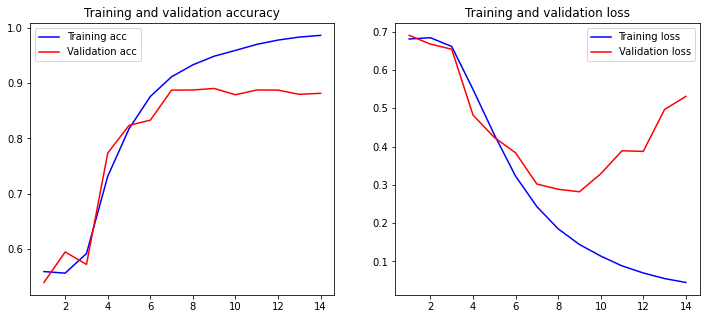

In [34]:
plot_history(history)


we have overfit but its do much better than classification with 5 category

we will try to training another model and hope to do better than this model

In [35]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.LSTM(128,return_sequences=True),
          keras.layers.GlobalMaxPool1D(),
          keras.layers.Dense(32,activation='relu'),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           12155400  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 128)           219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,379,209
Trainable params: 12,379,209
Non-trainable params: 0
____________________________________________

In [36]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Binary_Classifaction_2.h5',save_best_only=True,monitor='val_loss')
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [37]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),batch_size=32,callbacks=[check_point,early_stop])

Epoch 1/20
669/669 [==============================] - 33s 47ms/step - loss: 0.5081 - accuracy: 0.7411 - val_loss: 0.3162 - val_accuracy: 0.8703
Epoch 2/20
669/669 [==============================] - 34s 51ms/step - loss: 0.2611 - accuracy: 0.8962 - val_loss: 0.2702 - val_accuracy: 0.8894
Epoch 3/20
669/669 [==============================] - 28s 42ms/step - loss: 0.1691 - accuracy: 0.9323 - val_loss: 0.2649 - val_accuracy: 0.8946
Epoch 4/20
669/669 [==============================] - 28s 42ms/step - loss: 0.1158 - accuracy: 0.9584 - val_loss: 0.2895 - val_accuracy: 0.8963
Epoch 5/20
669/669 [==============================] - 28s 41ms/step - loss: 0.0634 - accuracy: 0.9787 - val_loss: 0.3703 - val_accuracy: 0.8830
Epoch 6/20
669/669 [==============================] - 28s 41ms/step - loss: 0.0326 - accuracy: 0.9895 - val_loss: 0.4051 - val_accuracy: 0.8937
Epoch 7/20
669/669 [==============================] - 32s 48ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.5132 - val_accuracy:

In [38]:
loss, accuracy = model.evaluate(X_train_set, y_train,verbose=False)
print("Training Accuracy:{:.4f} ".format(accuracy))
loss, accuracy = model.evaluate(X_test_set, y_test,verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy:0.9995 
Testing Accuracy:  0.8889


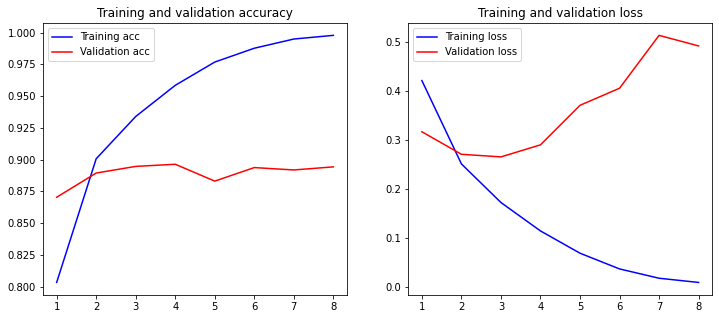

In [39]:
plot_history(history)

the previous model is better than this

The last model we will try on th binary classification

In [51]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=70),
          keras.layers.GRU(64,return_sequences=True,recurrent_dropout=0.2),
          keras.layers.GRU(64),
          keras.layers.Dropout(0.24),
          keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           12155400  
_________________________________________________________________
gru (GRU)                    (None, 70, 64)            70272     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,250,697
Trainable params: 12,250,697
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Binary_Classifaction_3.h5',save_best_only=True,monitor='val_loss')
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),batch_size=32,callbacks=[check_point,early_stop])